# Coursework Question 4

Use this notebook as a template for Question 4 - Multi-objective Optimization of Coursework 1.

<span style = "color:limegreen;"> Before beginning I would suggest making a copy of this file to avoid any Git conflicts!</span>

**Question**

An architect has asked you determine what the optimize the design parameters for the window assemblies on a building they are designing. The proposed building is highly glazed, naturally ventilated and in a temperate climate. The design parameters which can be varied are the window-to-wall ratio, depth of the fixed shading, and the u and g-values of the window assembly. The values that they have asked you to optimize are:

<ol type="a">
  <li>Heating energy demand</li>
  <li>Interior lighting energy usage </li>
  <li>Overheating risk</li>
</ol>

You have already performed a number of simulations and retrieved all of the necessary outputs. Your task is to use **both** the pareto front and weighted-sum methods to determine what the optimum design solutions are to this multi-objective problem.

For both methods, Compare the three sets of bi-objective optimizations (a and b; a and c; b and c) and the one tri-objective problem (a, b, and c). When using the weighted-sum first assume that each objective has equal weighting.

Discuss the results of your analysis. What were the optimal solutions returned? Compare the results of the weighted sum method to the pareto front approach, and the results of each combination of objective. Comment on which you think is the best approach and why and any adjustments you would make to the procedure.

## Load all of the necessary Python packages
All packages should work with Conda environment if installed on your machine. Otherwise all necessary packages can be installed in a virtual environment (.venv) in VS Code using: Ctrl+Shift+P > Python: Create Environment > Venv > Python 3.12.x > requirements.txt

<span style="color:orange;"> NOTE: that we are using the paretoset package will be used. You may need to install this package using pip.</span>

In [29]:
# 0) Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from paretoset import paretoset

plt.rcParams["figure.dpi"] = 140
plt.rcParams["axes.grid"] = True


## 1. Load the data.

The data is located in *outputs/dataset_Coursework_Question4.csv.


In [31]:
# 1) Load the data
# Adjust the path if your file lives somewhere else
csv_path = "/Users/rf/Documents/Data Analytics/BENV0166_2025/supplementaryData/dataset_Coursework_Question4.csv"
df_raw = pd.read_csv(csv_path)

print("Columns:", list(df_raw.columns))
print(df_raw.head(2))


Columns: ['Unnamed: 0', 'u_windows', 'g_value', 'wwr', 'fixedShadingDepth', 'heatingSum', 'heatingMax', 'lightingSum', 'temperature>28C']
   Unnamed: 0  u_windows  g_value  wwr  fixedShadingDepth    heatingSum  \
0           0        0.5      0.2  0.4               0.01  1.122787e+09   
1           1        0.5      0.2  0.4               0.25  1.144814e+09   

   heatingMax   lightingSum  temperature>28C  
0  1891.31322  5.128565e+08             1147  
1  2167.00317  5.128577e+08             1138  


### 1.1 Convert the raw data into more practical units
The data should contain four columns with building attributes (U-value of windows, g-value of windows, WWR, and the fixed shading depth) plus four columns of performance data. These are the annual sums of lighting and heating energy usage, the peak heating load, and the number of hours above 28C inside the building.

<span style="color:orange;"> Remember that EnergyPlus outputs are in base SI units. </span>

* lightingSum is given in Joules. Convert --> MJ
* heatingSum is given in Joules. Convert --> MJ
* heatingMax is given in Watts. Convert --> kW
* temperature>28C is given in hours.

NOTE: That we won't be using the output *heatingMax* for this exercise.

In [33]:
# 1.1) Unit conversion and tidy column names
df = df_raw.copy()

# your CSV snippet suggested these original column names:
#  u_windows, g_value, wwr, fixedShadingDepth, heatingSum (J), heatingMax (W), lightingSum (J), temperature>28C (h)
# convert and rename for clarity
df["Heating_MJ"]      = df["heatingSum"]   / 1e6       # J → MJ
df["Lighting_MJ"]     = df["lightingSum"]  / 1e6       # J → MJ
df["Overheat_hours"]  = df["temperature>28C"].astype(float) # already in hours
df["HeatingMax_kW"]   = df["heatingMax"]   / 1000.0    # W → kW (not used later but kept for reference)

# design variables (keep original names but also provide readable aliases)
df["WWR"]          = df["wwr"]
df["ShadingDepth"] = df["fixedShadingDepth"]
df["UValue"]       = df["u_windows"]
df["GValue"]       = df["g_value"]

# A clean view
cols_show = ["WWR","ShadingDepth","UValue","GValue","Heating_MJ","Lighting_MJ","Overheat_hours","HeatingMax_kW"]
print(df[cols_show].describe().round(3))


# Helper: pretty print the winning design (original units)
design_cols = ["WWR","ShadingDepth","UValue","GValue"]
def print_winner(idx, *objective_cols, title="Winner"):
    row = df.loc[idx, design_cols + list(objective_cols)].copy()
    print(title)
    print(row.to_frame().T.to_string(index=False))


           WWR  ShadingDepth   UValue  GValue  Heating_MJ  Lighting_MJ  \
count  882.000       882.000  882.000   882.0     882.000      882.000   
mean     0.500         0.751    2.125     0.5    2990.256      512.537   
std      0.082         0.498    1.915     0.2    3437.226        0.414   
min      0.400         0.010    0.500     0.2     327.809      511.366   
25%      0.400         0.250    0.750     0.3     776.403      512.244   
50%      0.500         0.750    1.250     0.5    1304.682      512.494   
75%      0.600         1.250    3.000     0.7    3762.679      512.872   
max      0.600         1.500    6.000     0.8   16870.040      513.405   

       Overheat_hours  HeatingMax_kW  
count         882.000        882.000  
mean         1653.531          3.510  
std           515.246          0.969  
min           721.000          1.761  
25%          1257.250          2.775  
50%          1595.000          3.420  
75%          1947.250          4.200  
max          3447.000

## 2. Analysis

<span style="color:limegreen;"> Complete the following analysis sections. You can re-use the code in exercise 4A and 4B to help complete the analysis.</span>

### 2.1 Pareto Front Analysis

<span style="color:limegreen;"> Perform the pareto front analysis for the three bi-objective problems and the tri-objective problems here. You are free to improve upon the analysis and visualisations too.</span>

#### 2.1.1 Heating and Lighting

#### 2.1.1 Heating and Lighting

47 solutions on the Pareto front for (Heating, Lighting).


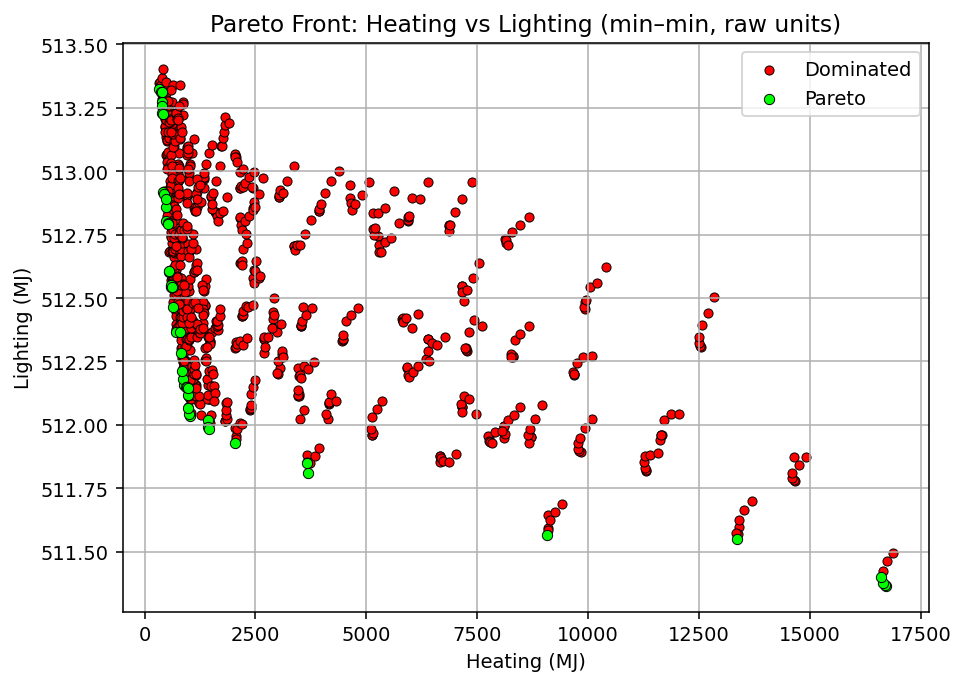

In [34]:
# 2.1.1) Pareto: Heating vs Lighting  (min, min) in RAW units
Jx, Jy = "Heating_MJ", "Lighting_MJ"

pareto_mask = paretoset(df[[Jx, Jy]], sense=["min","min"])
on  = df.loc[pareto_mask]
off = df.loc[~pareto_mask]

print(f"{pareto_mask.sum()} solutions on the Pareto front for (Heating, Lighting).")

fig, ax = plt.subplots()
ax.scatter(off[Jx], off[Jy], c="red",  s=22, linewidths=0.5, edgecolors="black", label="Dominated")
ax.scatter(on[Jx],  on[Jy],  c="lime", s=28, linewidths=0.5, edgecolors="black", label="Pareto")
ax.set_xlabel("Heating (MJ)")
ax.set_ylabel("Lighting (MJ)")
ax.set_title("Pareto Front: Heating vs Lighting (min–min, raw units)")
ax.legend()
plt.tight_layout()
plt.show()


#### 2.1.2 Heating and Overheating

32 solutions on the Pareto front for (Heating, Overheating).


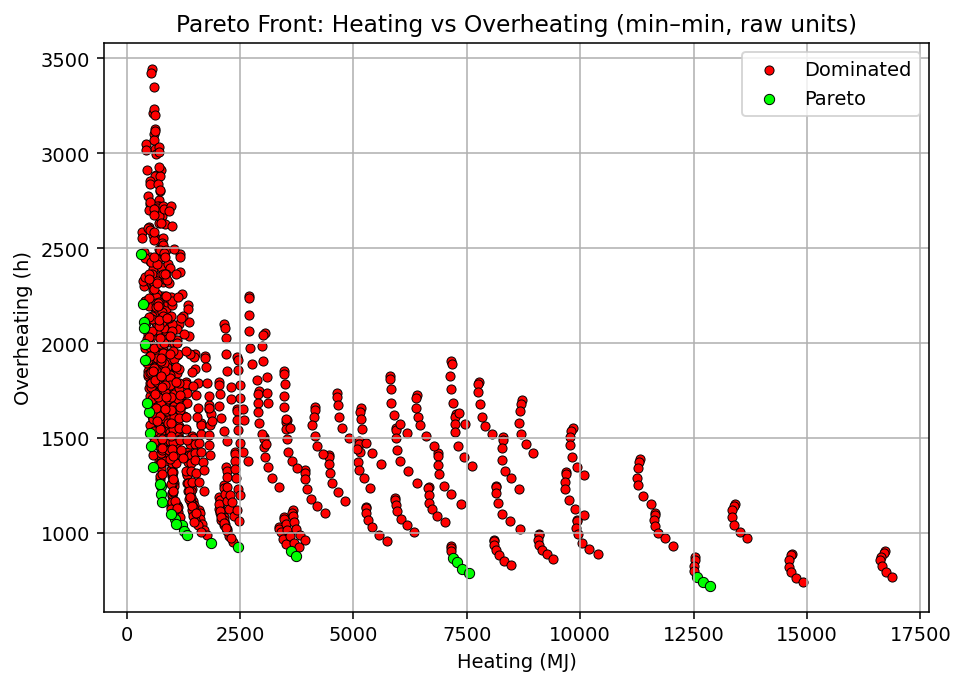

In [35]:
# 2.1.2) Pareto: Heating vs Overheating  (min, min)
Jx, Jy = "Heating_MJ", "Overheat_hours"

pareto_mask = paretoset(df[[Jx, Jy]], sense=["min","min"])
on  = df.loc[pareto_mask]
off = df.loc[~pareto_mask]

print(f"{pareto_mask.sum()} solutions on the Pareto front for (Heating, Overheating).")

fig, ax = plt.subplots()
ax.scatter(off[Jx], off[Jy], c="red",  s=22, linewidths=0.5, edgecolors="black", label="Dominated")
ax.scatter(on[Jx],  on[Jy],  c="lime", s=28, linewidths=0.5, edgecolors="black", label="Pareto")
ax.set_xlabel("Heating (MJ)")
ax.set_ylabel("Overheating (h)")
ax.set_title("Pareto Front: Heating vs Overheating (min–min, raw units)")
ax.legend()
plt.tight_layout()
plt.show()


#### 2.1.3 Overheating and Lighting

10 solutions on the Pareto front for (Overheating, Lighting).


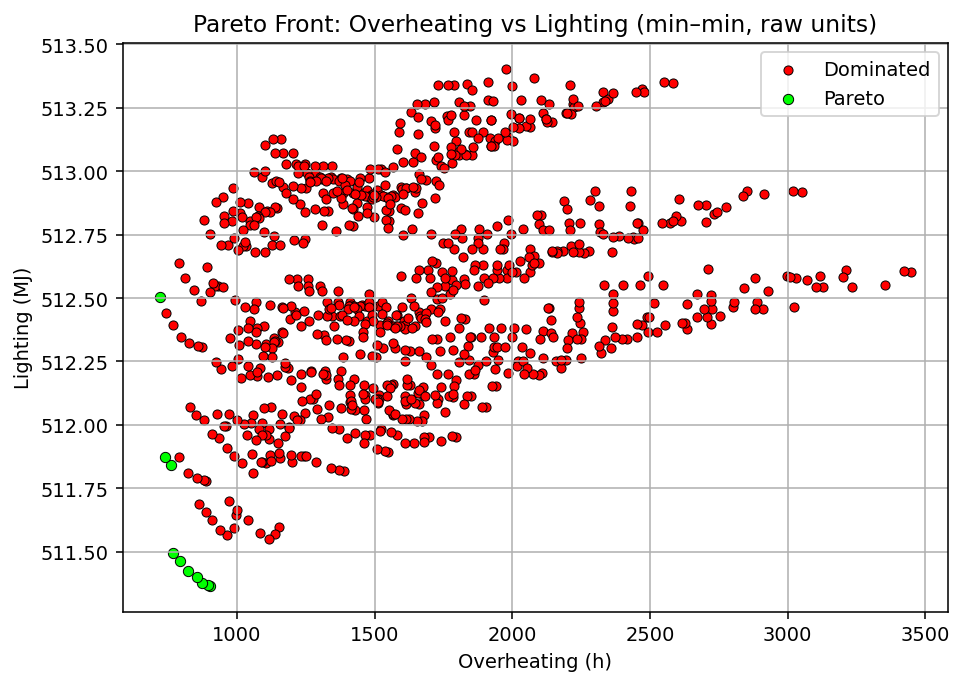

In [36]:
# 2.1.3) Pareto: Overheating vs Lighting (min, min)
Jx, Jy = "Overheat_hours", "Lighting_MJ"

pareto_mask = paretoset(df[[Jx, Jy]], sense=["min","min"])
on  = df.loc[pareto_mask]
off = df.loc[~pareto_mask]

print(f"{pareto_mask.sum()} solutions on the Pareto front for (Overheating, Lighting).")

fig, ax = plt.subplots()
ax.scatter(off[Jx], off[Jy], c="red",  s=22, linewidths=0.5, edgecolors="black", label="Dominated")
ax.scatter(on[Jx],  on[Jy],  c="lime", s=28, linewidths=0.5, edgecolors="black", label="Pareto")
ax.set_xlabel("Overheating (h)")
ax.set_ylabel("Lighting (MJ)")
ax.set_title("Pareto Front: Overheating vs Lighting (min–min, raw units)")
ax.legend()
plt.tight_layout()
plt.show()


#### 2.1.4 Heating, Lighting, and Overheating

164 solutions on the tri-objective Pareto front.



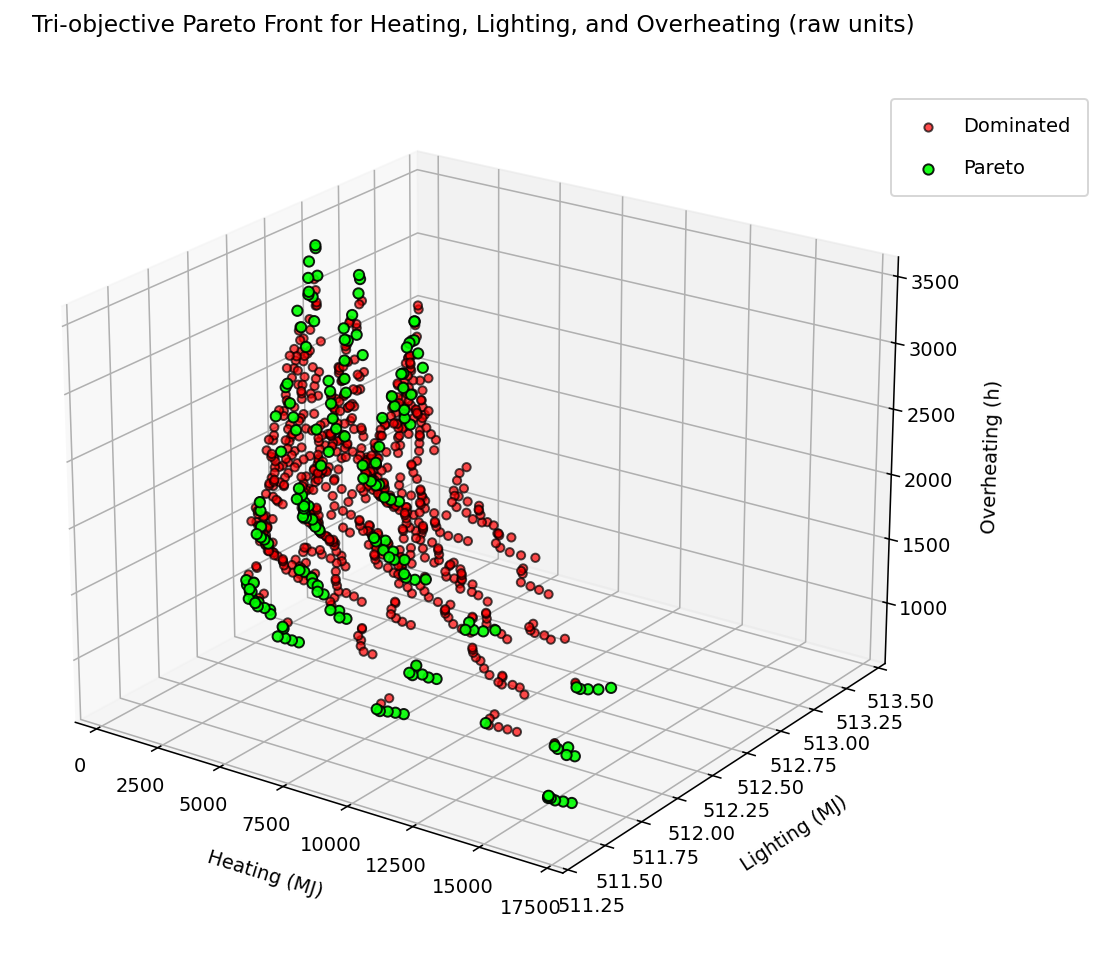

In [52]:
# 2.1.4 Tri-objective Pareto Front (Heating, Lighting, Overheating, raw units)

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt

# --- Define objectives ---
tri_cols = ["Heating_MJ", "Lighting_MJ", "Overheat_hours"]

# Compute Pareto front
pareto_abc = paretoset(df[tri_cols], sense=["min", "min", "min"])
on_abc  = df[pareto_abc]
off_abc = df[~pareto_abc]

print(f"{pareto_abc.sum()} solutions on the tri-objective Pareto front.\n")

# --- Plot ---
fig = plt.figure(figsize=(13, 8))
ax  = fig.add_subplot(111, projection="3d")
fig.subplots_adjust(left=0.06, right=0.85, bottom=0.08, top=0.90)  # add right margin

# Dominated and Pareto points
ax.scatter(off_abc["Heating_MJ"], off_abc["Lighting_MJ"], off_abc["Overheat_hours"],
           c="red", s=18, edgecolors="black", alpha=0.70, label="Dominated", zorder=1)
ax.scatter(on_abc["Heating_MJ"],  on_abc["Lighting_MJ"],  on_abc["Overheat_hours"],
           c="lime", s=28, edgecolors="black", alpha=0.90, label="Pareto", zorder=2)

# Axes and view
ax.set_xlabel("Heating (MJ)",    labelpad=10)
ax.set_ylabel("Lighting (MJ)",   labelpad=10)
ax.set_zlabel("Overheating (h)", labelpad=10)
ax.view_init(elev=22, azim=-55)

# Legend — aligned with section 2.2 style
ax.legend(loc="upper right", bbox_to_anchor=(1.18, 0.95),
           borderpad=0.9, labelspacing=1.2, fontsize=10)

# Improved title
ax.set_title("Tri-objective Pareto Front for Heating, Lighting, and Overheating (raw units)")

plt.show()


### 2.2 Weighted Sum Analysis

#### 2.2.1 Heating and Lighting

Weighted-sum (equal, normalised) best for (Heating, Lighting)
 WWR  ShadingDepth  UValue  GValue  Heating_MJ  Lighting_MJ
 0.6           1.0    0.75     0.2 1440.319948    511.98258


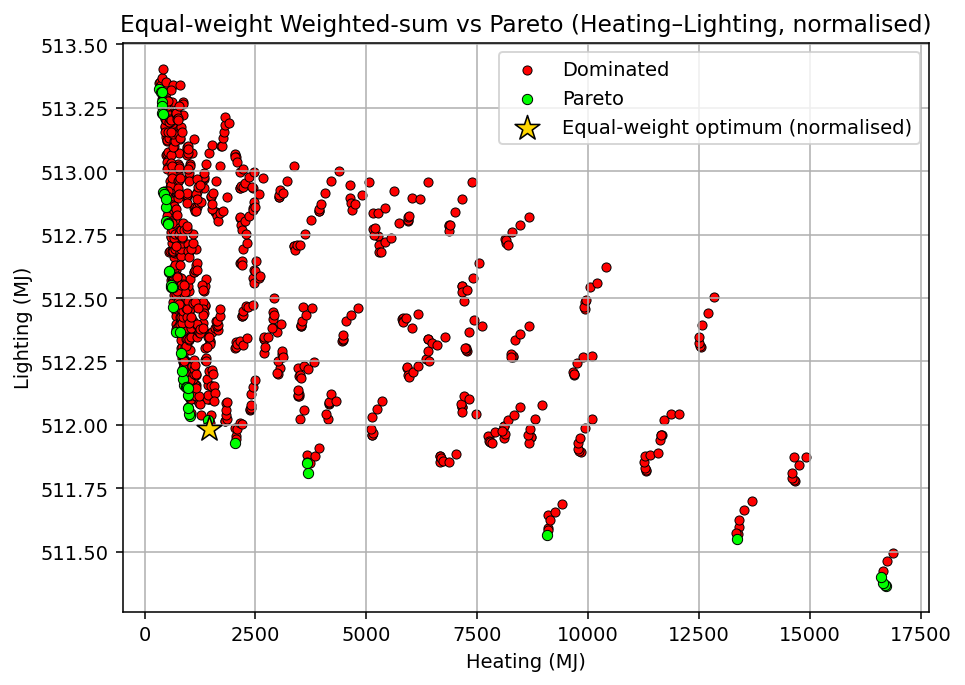

In [53]:
# 2.2.1) Weighted-sum (equal, NORMALISED) vs Pareto for Heating–Lighting
Jx, Jy = "Heating_MJ", "Lighting_MJ"

# Pareto for context
pareto_mask = paretoset(df[[Jx, Jy]], sense=["min", "min"])
on  = df.loc[pareto_mask]
off = df.loc[~pareto_mask]

# Normalise both objectives (0–1 range)
Jx_norm = (df[Jx] - df[Jx].min()) / (df[Jx].max() - df[Jx].min())
Jy_norm = (df[Jy] - df[Jy].min()) / (df[Jy].max() - df[Jy].min())

# Equal weights on normalised values
score = 0.5 * Jx_norm + 0.5 * Jy_norm
best_idx = int(score.idxmin())

print_winner(best_idx, Jx, Jy, title="Weighted-sum (equal, normalised) best for (Heating, Lighting)")

# Plot
fig, ax = plt.subplots()
ax.scatter(off[Jx], off[Jy], c="red",  s=22, linewidths=0.5, edgecolors="black", label="Dominated")
ax.scatter(on[Jx],  on[Jy],  c="lime", s=28, linewidths=0.5, edgecolors="black", label="Pareto")

# Highlight the equal-weight optimum (normalised)
ax.scatter(df.loc[best_idx, Jx], df.loc[best_idx, Jy],
           c="gold", marker="*", s=180, linewidths=0.8, edgecolors="black",
           label="Equal-weight optimum (normalised)", zorder=10)

ax.set_xlabel("Heating (MJ)")
ax.set_ylabel("Lighting (MJ)")
ax.set_title("Equal-weight Weighted-sum vs Pareto (Heating–Lighting, normalised)")
ax.legend()
plt.tight_layout()
plt.show()


#### 2.2.2 Heating and Overheating

Weighted-sum (equal, normalised) best for (Heating, Overheating)
 WWR  ShadingDepth  UValue  GValue  Heating_MJ  Overheat_hours
 0.4           1.5     0.5     0.2 1338.521208           987.0


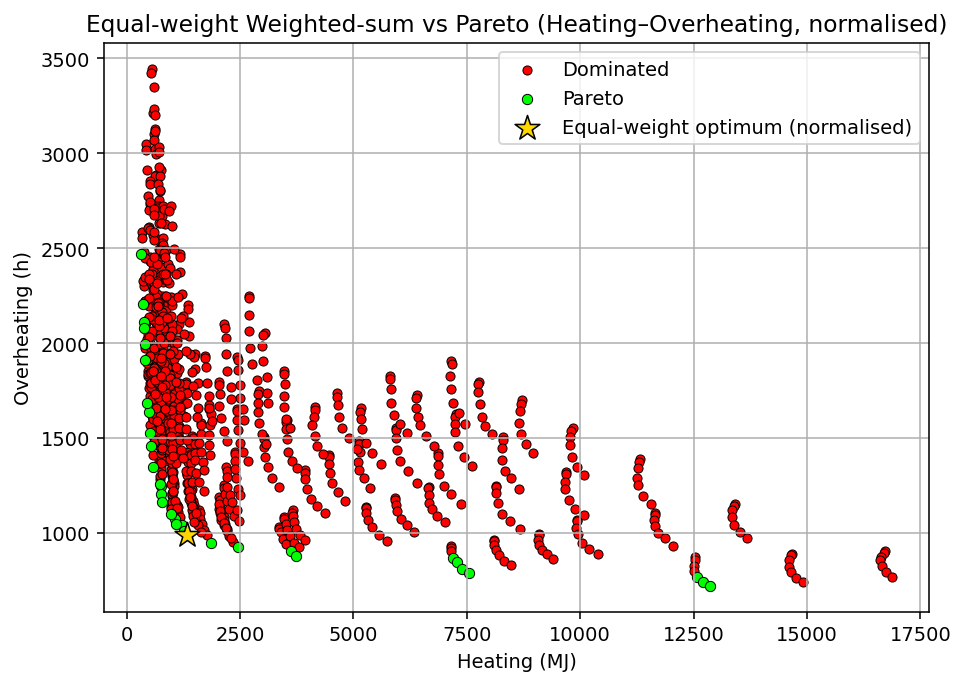

In [57]:
# 2.2.2) Weighted-sum (equal, NORMALISED) vs Pareto for Heating–Overheating
Jx, Jy = "Heating_MJ", "Overheat_hours"

# Pareto for context
pareto_mask = paretoset(df[[Jx, Jy]], sense=["min", "min"])
on  = df.loc[pareto_mask]
off = df.loc[~pareto_mask]

# Normalise both objectives (0–1 range)
Jx_norm = (df[Jx] - df[Jx].min()) / (df[Jx].max() - df[Jx].min())
Jy_norm = (df[Jy] - df[Jy].min()) / (df[Jy].max() - df[Jy].min())

# Equal weights on normalised objectives
score = 0.5 * Jx_norm + 0.5 * Jy_norm
best_idx = int(score.idxmin())

print_winner(best_idx, Jx, Jy, title="Weighted-sum (equal, normalised) best for (Heating, Overheating)")

# Plot
fig, ax = plt.subplots()
ax.scatter(off[Jx], off[Jy], c="red",  s=22, linewidths=0.5, edgecolors="black", label="Dominated")
ax.scatter(on[Jx],  on[Jy],  c="lime", s=28, linewidths=0.5, edgecolors="black", label="Pareto")

# Highlight the equal-weight optimum (normalised)
ax.scatter(df.loc[best_idx, Jx], df.loc[best_idx, Jy],
           c="gold", marker="*", s=180, linewidths=0.8, edgecolors="black",
           label="Equal-weight optimum (normalised)", zorder=10)

ax.set_xlabel("Heating (MJ)")
ax.set_ylabel("Overheating (h)")
ax.set_title("Equal-weight Weighted-sum vs Pareto (Heating–Overheating, normalised)")
ax.legend()
plt.tight_layout()
plt.show()


164 solutions on the tri-objective Pareto front.



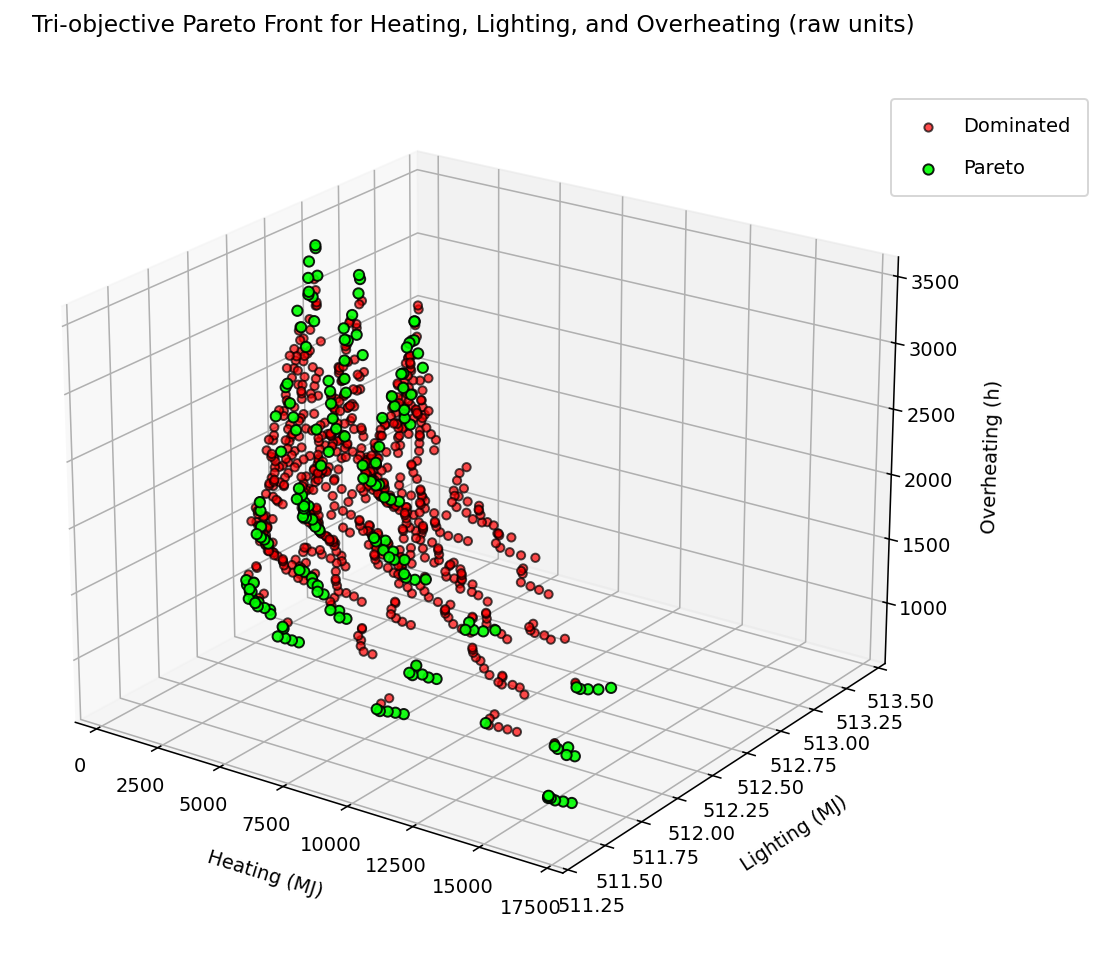

In [ ]:
# 2.1.4 Tri-objective Pareto Front (Heating, Lighting, Overheating, raw units)

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt

# --- Define objectives ---
tri_cols = ["Heating_MJ", "Lighting_MJ", "Overheat_hours"]

# Compute Pareto front
pareto_abc = paretoset(df[tri_cols], sense=["min", "min", "min"])
on_abc  = df[pareto_abc]
off_abc = df[~pareto_abc]

print(f"{pareto_abc.sum()} solutions on the tri-objective Pareto front.\n")

# --- Plot ---
fig = plt.figure(figsize=(13, 8))
ax  = fig.add_subplot(111, projection="3d")
fig.subplots_adjust(left=0.06, right=0.85, bottom=0.08, top=0.90)  # add right margin

# Dominated and Pareto points
ax.scatter(off_abc["Heating_MJ"], off_abc["Lighting_MJ"], off_abc["Overheat_hours"],
           c="red", s=18, edgecolors="black", alpha=0.70, label="Dominated", zorder=1)
ax.scatter(on_abc["Heating_MJ"],  on_abc["Lighting_MJ"],  on_abc["Overheat_hours"],
           c="lime", s=28, edgecolors="black", alpha=0.90, label="Pareto", zorder=2)

# Axes and view
ax.set_xlabel("Heating (MJ)",    labelpad=10)
ax.set_ylabel("Lighting (MJ)",   labelpad=10)
ax.set_zlabel("Overheating (h)", labelpad=10)
ax.view_init(elev=22, azim=-55)

# Legend — aligned with section 2.2 style
ax.legend(loc="upper right", bbox_to_anchor=(1.18, 0.95),
           borderpad=0.9, labelspacing=1.2, fontsize=10)

# Improved title
ax.set_title("Tri-objective Pareto Front for Heating, Lighting, and Overheating (raw units)")

plt.show()


#### 2.2.3 Overheating and Lighting

Weighted-sum (equal, normalised) best for (Overheating, Lighting)
 WWR  ShadingDepth  UValue  GValue  Overheat_hours  Lighting_MJ
 0.6           0.5     6.0     0.2           875.0   511.376529


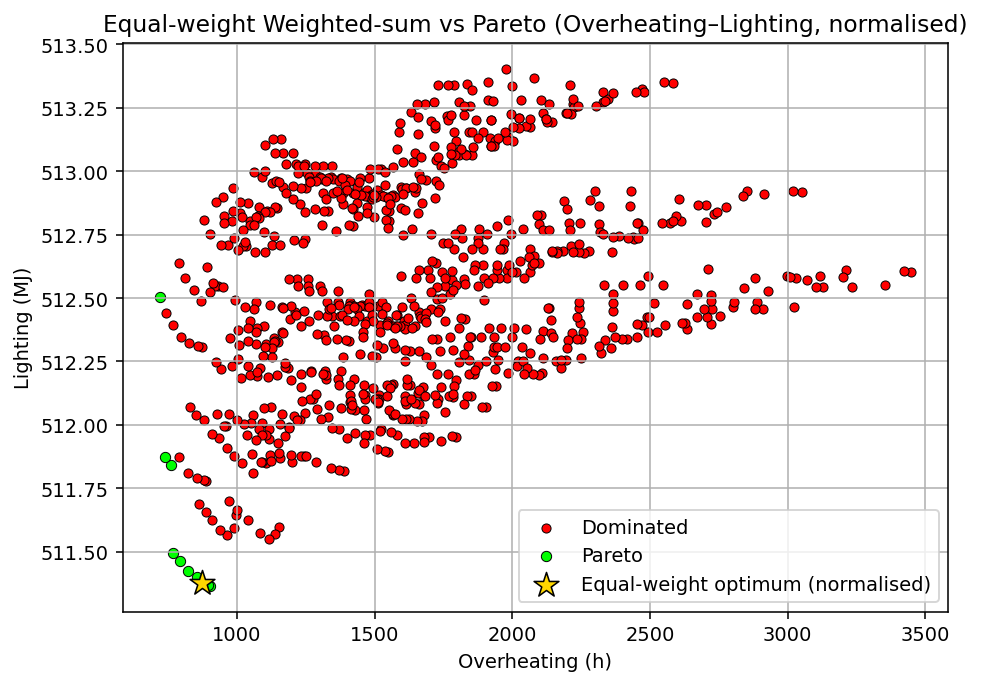

In [55]:
# 2.2.3) Weighted-sum (equal, NORMALISED) vs Pareto for Overheating–Lighting
Jx, Jy = "Overheat_hours", "Lighting_MJ"

# Pareto for context
pareto_mask = paretoset(df[[Jx, Jy]], sense=["min", "min"])
on  = df.loc[pareto_mask]
off = df.loc[~pareto_mask]

# Normalise both objectives (0–1 range)
Jx_norm = (df[Jx] - df[Jx].min()) / (df[Jx].max() - df[Jx].min())
Jy_norm = (df[Jy] - df[Jy].min()) / (df[Jy].max() - df[Jy].min())

# Equal weights on normalised objectives
score = 0.5 * Jx_norm + 0.5 * Jy_norm
best_idx = int(score.idxmin())

print_winner(best_idx, Jx, Jy, title="Weighted-sum (equal, normalised) best for (Overheating, Lighting)")

# Plot
fig, ax = plt.subplots()
ax.scatter(off[Jx], off[Jy], c="red",  s=22, linewidths=0.5, edgecolors="black", label="Dominated")
ax.scatter(on[Jx],  on[Jy],  c="lime", s=28, linewidths=0.5, edgecolors="black", label="Pareto")

# Highlight the equal-weight optimum (normalised)
ax.scatter(df.loc[best_idx, Jx], df.loc[best_idx, Jy],
           c="gold", marker="*", s=180, linewidths=0.8, edgecolors="black",
           label="Equal-weight optimum (normalised)", zorder=10)

ax.set_xlabel("Overheating (h)")
ax.set_ylabel("Lighting (MJ)")
ax.set_title("Equal-weight Weighted-sum vs Pareto (Overheating–Lighting, normalised)")
ax.legend()
plt.tight_layout()
plt.show()


#### 2.2.4 Heating, Lighting, and Overheating

164 solutions on the tri-objective Pareto front.

Weighted–sum (equal, normalised) best for (Heating, Lighting, Overheating):
 WWR  ShadingDepth  UValue  GValue  Heating_MJ  Lighting_MJ  Overheat_hours
 0.6           1.0    0.75     0.2 1440.319948    511.98258          1118.0



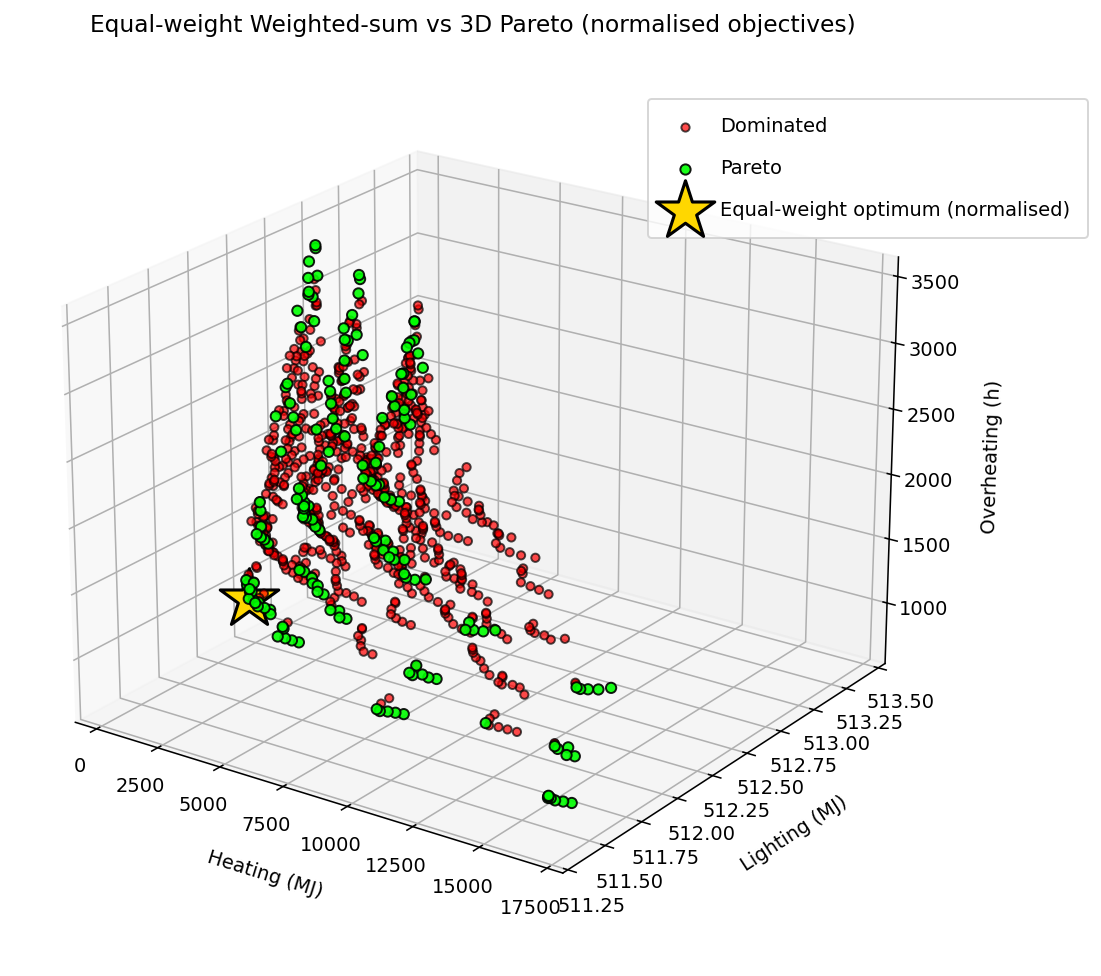

In [56]:
# 2.2.4) Weighted-sum (equal, NORMALISED) vs 3D Pareto: Heating, Lighting, Overheating
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import matplotlib.pyplot as plt

# --- Objectives and Pareto set (all minimised) ---
tri_cols = ["Heating_MJ", "Lighting_MJ", "Overheat_hours"]
pareto_abc = paretoset(df[tri_cols], sense=["min", "min", "min"])
on_abc  = df.loc[pareto_abc]
off_abc = df.loc[~pareto_abc]

print(f"{pareto_abc.sum()} solutions on the tri-objective Pareto front.\n")

# --- Normalise each objective to 0–1 (min–max across full design set) ---
df_norm = df.copy()
for col in tri_cols:
    cmin, cmax = df[col].min(), df[col].max()
    df_norm[col] = (df[col] - cmin) / (cmax - cmin)

# --- Equal-weight weighted-sum in NORMALISED space ---
ws_eq_3d = (df_norm["Heating_MJ"] + df_norm["Lighting_MJ"] + df_norm["Overheat_hours"]) / 3.0
best_idx = int(ws_eq_3d.idxmin())

# --- Report chosen design (raw units for interpretability) ---
cols_to_show = ["WWR", "ShadingDepth", "UValue", "GValue",
                "Heating_MJ", "Lighting_MJ", "Overheat_hours"]
row = df.loc[best_idx, cols_to_show].copy()
print("Weighted–sum (equal, normalised) best for (Heating, Lighting, Overheating):")
print(row.to_frame().T.to_string(index=False))
print()

# --- 3D scatter plot ---
fig = plt.figure(figsize=(13, 8))
ax  = fig.add_subplot(111, projection="3d")
fig.subplots_adjust(left=0.06, right=0.85, bottom=0.08, top=0.90)

# Dominated & Pareto points
ax.scatter(off_abc["Heating_MJ"], off_abc["Lighting_MJ"], off_abc["Overheat_hours"],
           c="red", s=18, edgecolors="black", alpha=0.70, label="Dominated", zorder=1)
ax.scatter(on_abc["Heating_MJ"],  on_abc["Lighting_MJ"],  on_abc["Overheat_hours"],
           c="lime", s=28, edgecolors="black", alpha=0.90, label="Pareto", zorder=2)

# Equal-weight optimum star (raw coordinates)
hx_star = df.loc[best_idx, "Heating_MJ"]
lx_star = df.loc[best_idx, "Lighting_MJ"]
oh_star = df.loc[best_idx, "Overheat_hours"]
ax.scatter(hx_star, lx_star, oh_star,
           c="gold", marker="*", s=1000, edgecolors="black", linewidths=1.6,
           depthshade=False, zorder=190, label="Equal-weight optimum (normalised)")

# Axes and layout
ax.set_xlabel("Heating (MJ)",    labelpad=10)
ax.set_ylabel("Lighting (MJ)",   labelpad=10)
ax.set_zlabel("Overheating (h)", labelpad=10)
ax.view_init(elev=22, azim=-55)

# Legend and title
ax.legend(loc="upper right", bbox_to_anchor=(1.18, 0.95), borderpad=0.9, labelspacing=1.2, fontsize=10)
ax.set_title("Equal-weight Weighted-sum vs 3D Pareto (normalised objectives)")

plt.show()


### 3. Additional analysis (optional)

In [ ]:
# Add code here